# Moving Average Trading Strategy with Python

The purpose of this script is to implement a very simple trading strategy with Python. This strategy is based on the difference between slow and fast moving averages on the adjusted closed price of HSBC share. First we describe the strategy in detail explaining various features and then we optimize it using Python libraries.  

In [209]:
import numpy as np
import pandas as pd
import yfinance as yf
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set()
import warnings
warnings.filterwarnings("ignore")

We focus on data of HSBC stock in the period between 2014/01/01 and 2024/01/01. We download our data and we compute the logarithmic. 

In [210]:
# Define stock and date range
stock = 'HSBC'
start = '2014-01-01'
end = '2024-01-01'

# Fetch the data using yfinance directly
data = yf.download(stock, start=start, end=end)

# Calculate log returns
data['Log Returns'] = np.log(data['Adj Close'] / data['Adj Close'].shift(1))

# Drop NA values
data.dropna(inplace=True)

# Display the first 5 rows of the data
print(data.head(5))

[*********************100%%**********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close   Volume  \
Date                                                                         
2014-01-03  54.040001  54.419998  54.029999  54.090000  29.469027  1021100   
2014-01-06  54.610001  54.810001  54.340000  54.360001  29.616133  1012200   
2014-01-07  55.490002  55.869999  55.340000  55.560001  30.269899  1844900   
2014-01-08  55.840000  55.950001  55.520000  55.590000  30.286245  1691800   
2014-01-09  55.410000  55.450001  55.169998  55.340000  30.150040  1424000   

            Log Returns  
Date                     
2014-01-03    -0.008835  
2014-01-06     0.004979  
2014-01-07     0.021835  
2014-01-08     0.000540  
2014-01-09    -0.004507  


The adj. close price during that period looks like this:

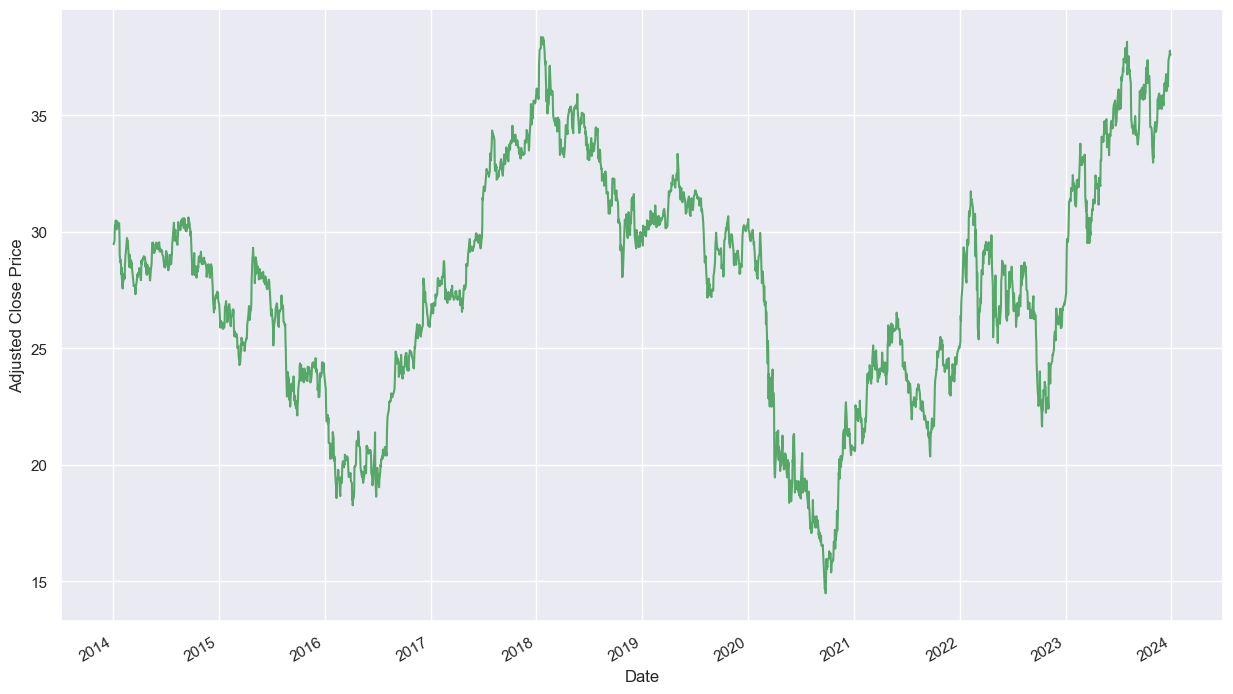

In [211]:
plt.figure(figsize = (15,9))
data['Adj Close'].plot(c = 'g')
plt.ylabel('Adjusted Close Price')
plt.show()

And here we plot the cumulative log returns $c_{t}$ and the total relative returns $c_{t}^{rel}$, given by:
$$
c_{t} = \sum_{k = 0}^{t} \ln(p_{k}/p_{k-1})\,,
$$
and
$$
c_{t}^{rel} = \exp(c_{t}) - 1
$$

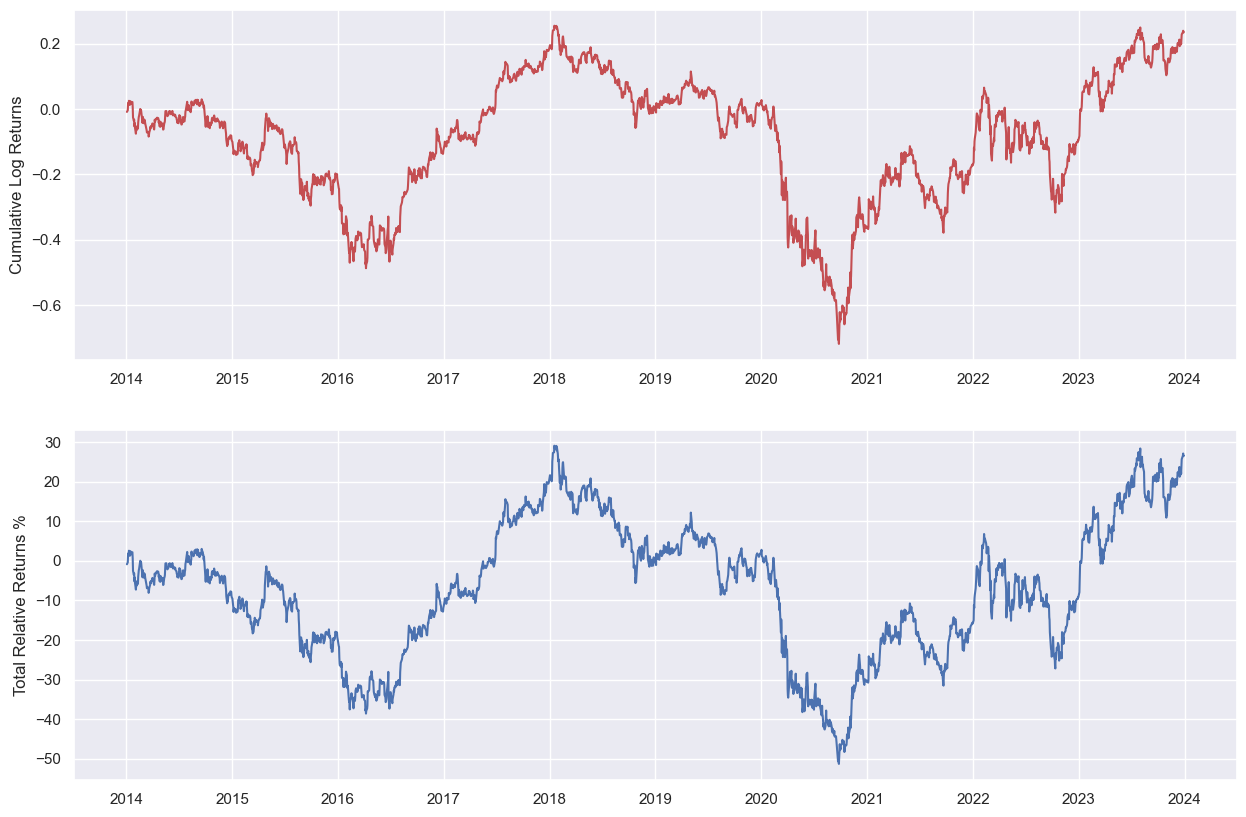

In [212]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,10))

ax1.plot(data['Log Returns'].cumsum(), c = 'r')
ax1.set_ylabel('Cumulative Log Returns')

ax2.plot(100*(np.exp(data['Log Returns'].cumsum())-1))
ax2.set_ylabel('Total Relative Returns %')

plt.show()

# ========================================================

We compute a fast moving average of 40 days (MA40) and a slow moving average of 252 days (MA252) on the Adj. Close Price. 

In [213]:
MAF = 42
MAS =252

data['MASlow'] = data['Adj Close'].rolling(MAS).mean()
data['MAFast'] = data['Adj Close'].rolling(MAF).mean()
data.dropna(inplace=True)
data.head()

,Open,High,Low,Close,Adj Close,Volume,Log Returns,MASlow,MAFast
Date,,,,,,,,,
2015-01-02,47.299999,47.330002,46.849998,47.070000,26.890633,1446500,-0.003393,28.888865,27.977579
2015-01-05,46.259998,46.340000,45.799999,45.990002,26.273642,2599600,-0.023212,28.876185,27.921674
2015-01-06,45.439999,45.680000,45.009998,45.320000,25.890873,3408100,-0.014676,28.861402,27.855840
2015-01-07,45.459999,45.720001,45.230000,45.669998,26.090826,2122400,0.007693,28.844819,27.790141
2015-01-08,45.630001,46.009998,45.630001,45.820000,26.176517,1601600,0.003279,28.828510,27.728387


Thus, the Adj.Close price and both our moving averages look like this:

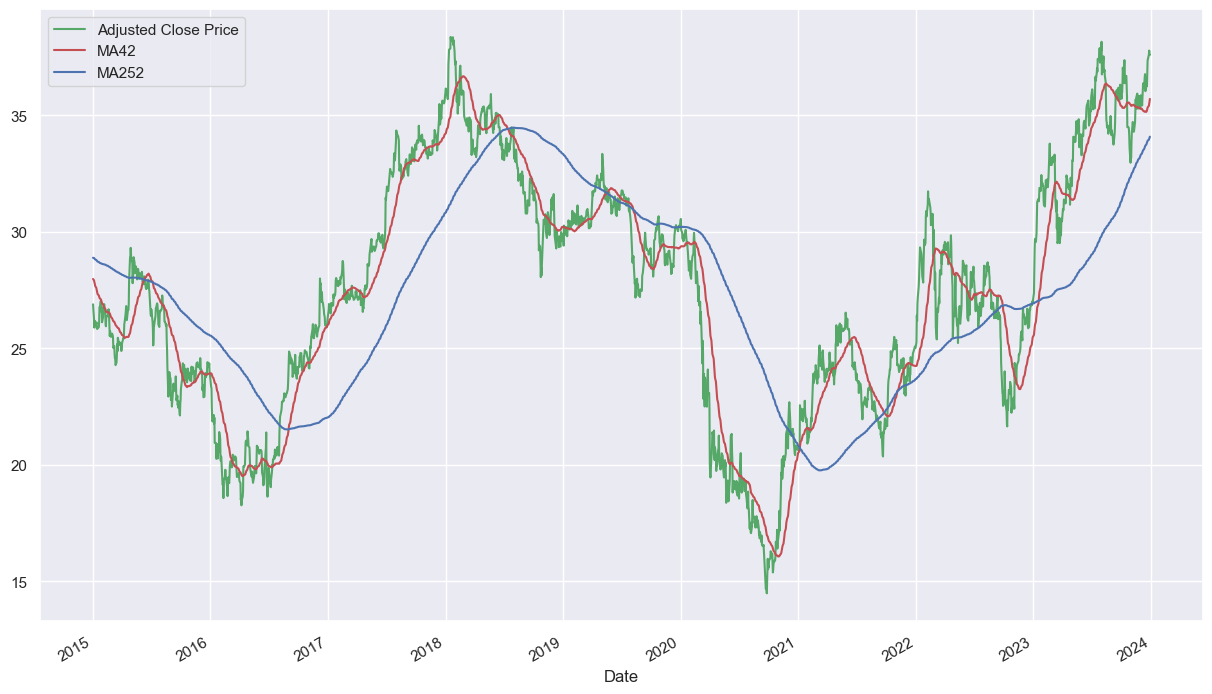

In [214]:
plt.figure(figsize= (15,9))
data['Adj Close'].plot(color = 'g', label = 'Adjusted Close Price')
data['MAFast'].plot(color = 'r', label = 'MA{}'.format(MAF) )
data['MASlow'].plot(color = 'b', label = 'MA{}'.format(MAS) )
plt.legend()
plt.show()

# ===========================================================

We will now follow a simple strategy: if M45 > M252, we then long one share of stock; otherwise, we do nothing. Our signal is then defined as 

In [215]:
data['Signal'] = np.where(data['MAFast']>data['MASlow'],1,-1)
data.dropna(inplace=True)
data.head()

,Open,High,Low,Close,Adj Close,Volume,Log Returns,MASlow,MAFast,Signal
Date,,,,,,,,,,
2015-01-02,47.299999,47.330002,46.849998,47.070000,26.890633,1446500,-0.003393,28.888865,27.977579,-1
2015-01-05,46.259998,46.340000,45.799999,45.990002,26.273642,2599600,-0.023212,28.876185,27.921674,-1
2015-01-06,45.439999,45.680000,45.009998,45.320000,25.890873,3408100,-0.014676,28.861402,27.855840,-1
2015-01-07,45.459999,45.720001,45.230000,45.669998,26.090826,2122400,0.007693,28.844819,27.790141,-1
2015-01-08,45.630001,46.009998,45.630001,45.820000,26.176517,1601600,0.003279,28.828510,27.728387,-1


We see that, I we were to follow this strategy, we would go long more often than short:

In [216]:

def count_signal(data):
    return data['Signal'].value_counts()
print(count_signal(data))


Signal
 1    1189
-1    1075
Name: count, dtype: int64


And here plot the adjusted close price for our stock, the slow/fast moving averages and the short/long signal:

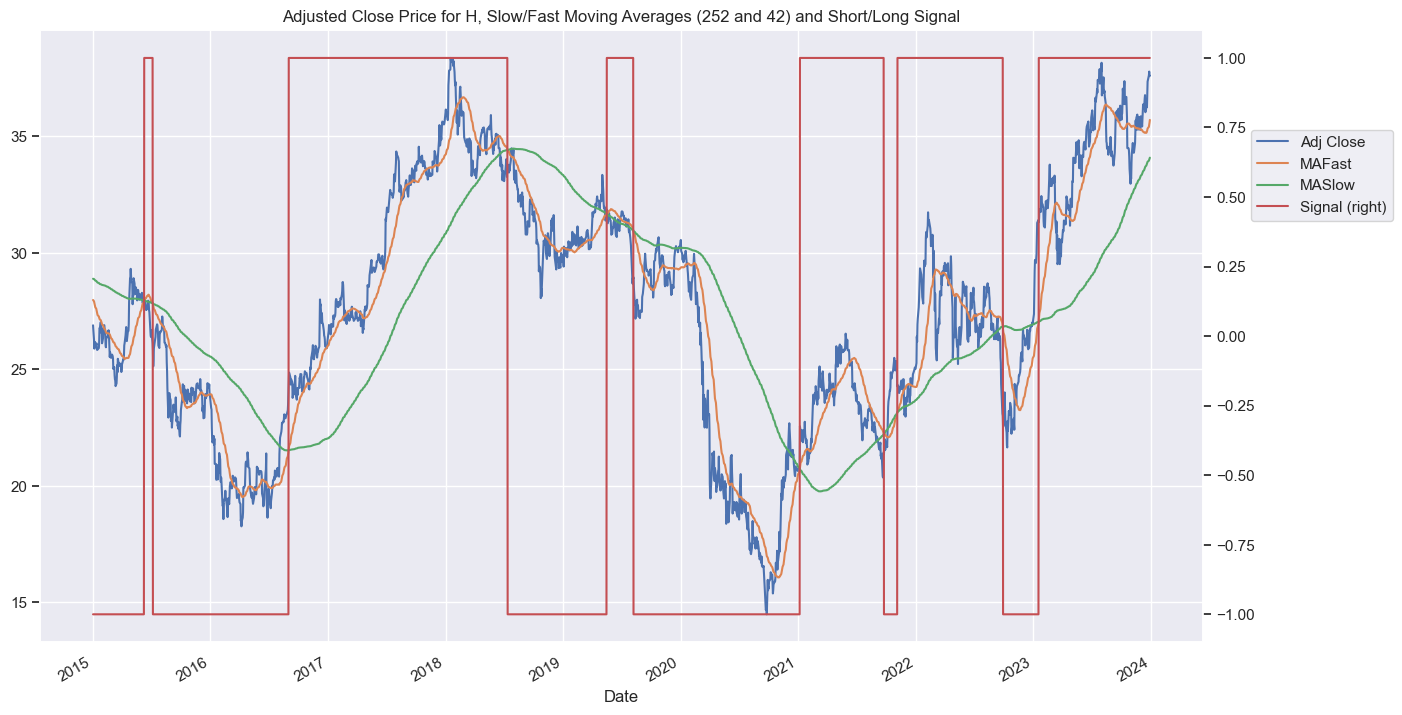

In [217]:
Ax = data[['Adj Close','MAFast','MASlow','Signal']].plot(secondary_y='Signal',figsize=(15,9),title='Adjusted Close Price for {}, Slow/Fast Moving Averages ({} and {}) and Short/Long Signal'.format(stock[0],MAS,MAF))
#Ax.title('Hello')
Ax.get_legend().set_bbox_to_anchor((1.17, 0.85))

# ========================================================

Following this strategy, the daily returns $R_{t}^{S}$ would be given by the product of the log return $R_{t}$ times our signal $O_{t}$, like so:
$$
R^{S}_{t} = O_{t} R_{t}
$$

In [218]:
data['Strategy Log Returns'] = data['Log Returns'] * data['Signal'].shift(1)
data.dropna(inplace=True)

(We note that we have shifted the signal for one day, since we implement the strategy on the day after the closing.)

The results of the strategy are not encouraging. We compare it to a 'Buy and Hold' strategy:

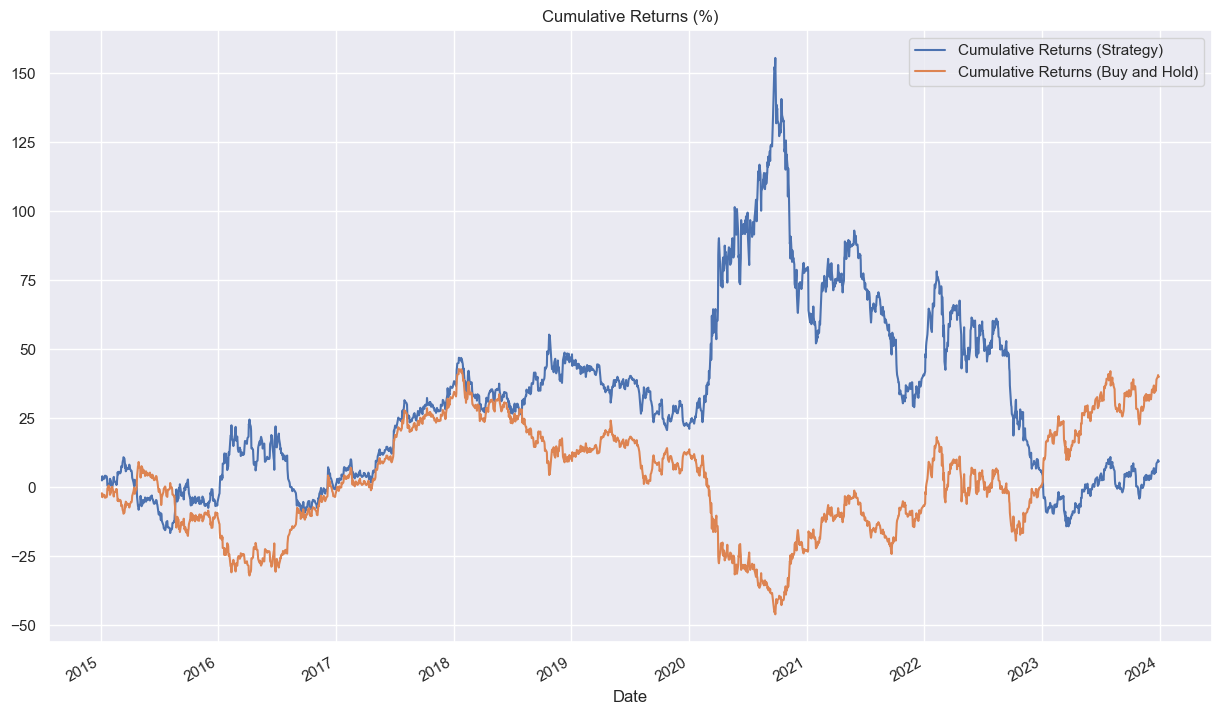

In [219]:
#print('Total Buy and Hold return (%) is : ', 100*(np.exp(data['Log Returns'].sum())-1).round(4),'%')
#print('Total strategy return (%) is : ', 100*(np.exp(data['Strategy Log Returns'].sum())-1).round(4),'%')

plt.figure(figsize = (15,9))
(100*(np.exp(data['Strategy Log Returns'].cumsum())-1)).plot(label = 'Cumulative Returns (Strategy)')
(100*(np.exp(data['Log Returns'].cumsum())-1)).plot(label = 'Cumulative Returns (Buy and Hold)')
plt.title('Cumulative Returns (%)')
plt.legend()
plt.show()


To evaluate the strategy better, we compute the total returns for the strategy and the market cases, as well as the annualized volatility:

In [220]:
print('Total Returns')
print(25*'===')
print('Market Total Return:',((np.exp(data[['Log Returns', 'Strategy Log Returns']].sum()) -1)*100).round(3).iloc[0],'%')
print('Strategy Total Return:',((np.exp(data[['Log Returns', 'Strategy Log Returns']].sum()) -1)*100).round(3).iloc[1],'%')

Total Returns
Market Total Return: 39.859 %
Strategy Total Return: 9.218 %


In [221]:
print('Annualized Volatility')
print(25*'===')
print('Market Volatility:',(data[['Log Returns', 'Strategy Log Returns']].std()*252**0.5).round(5).iloc[0],'%')
print('Strategy Volatility:',(data[['Log Returns', 'Strategy Log Returns']].std()*252**0.5).round(5).iloc[1],'%')

Annualized Volatility
Market Volatility: 0.25308 %
Strategy Volatility: 0.25309 %


# ===========================================================

#### Now, we make a general script. Given the HSBC stock, the start and ending dates and our fast and slow moving averages, we will obtain: 
1. A plot showing the adj. close price, the MAs and the strategy signal.
2. A plot comparing the market and strategy relative cumulative returns.
3. Information about the market and strategy total returns and annualized volatility.

In [222]:
def MA_Strategy(stock, start, end, MAF, MAS):
    try:
        data = yf.download(stock, start=start, end=end)
    except Exception as e:
        print(f"Failed to download data for {stock}: {e}")
        return
    
    if data.empty:
        print(f"No data found for {stock}")
        return

    data['Log Returns'] = np.log(data['Adj Close'] / data['Adj Close'].shift(1))
    data.dropna(inplace=True)
    
    data['MASlow'] = data['Adj Close'].rolling(MAS).mean()
    data['MAFast'] = data['Adj Close'].rolling(MAF).mean()
    data.dropna(inplace=True)
    
    data['Signal'] = np.where(data['MAFast'] > data['MASlow'], 1, -1)
    data.dropna(inplace=True)
    
    data['Strategy Log Returns'] = data['Log Returns'] * data['Signal'].shift(1)
    data.dropna(inplace=True)
    
    # Plot adjusted close price and moving averages
    ax = data[['Adj Close', 'MAFast', 'MASlow']].plot(figsize=(15, 9))
    ax2 = ax.twinx()
    data['Signal'].plot(ax=ax2, color='r', linestyle='--', alpha=0.5, secondary_y=True)
    ax.set_title(f'Adjusted Close Price for {stock}, Slow/Fast Moving Averages ({MAS} and {MAF}) and Short/Long Signal')
    ax.get_legend().set_bbox_to_anchor((1.17, 0.85))
    
    # Plot cumulative returns
    plt.figure(figsize=(15, 9))
    (100 * (np.exp(data['Strategy Log Returns'].cumsum()) - 1)).plot(label='Cumulative Returns (Strategy)')
    (100 * (np.exp(data['Log Returns'].cumsum()) - 1)).plot(label='Cumulative Returns (Buy and Hold)')
    plt.title(f'Cumulative Returns (%): {stock}')
    plt.legend()
    plt.show()
    
    # Print performance metrics
    print('\n')
    print(f'Total Returns: {stock}')
    print(35 * '=')
    print(f'Market Total Return: {((np.exp(data[['Log Returns', 'Strategy Log Returns']].sum()) - 1) * 100).round(3).iloc[0]}%')
    print(f'Strategy Total Return: {((np.exp(data[['Log Returns', 'Strategy Log Returns']].sum()) - 1) * 100).round(3).iloc[1]}%')
    print('\n')
    print(f'Annualized Volatility: {stock}')
    print(35 * '=')
    print(f'Market Volatility: {(data[['Log Returns', 'Strategy Log Returns']].std() * 252**0.5).round(5).iloc[0]}%')
    print(f'Strategy Volatility: {(data[['Log Returns', 'Strategy Log Returns']].std() * 252**0.5).round(5).iloc[1]}%')

We try with HSBC stock, just to check:

[*********************100%%**********************]  1 of 1 completed


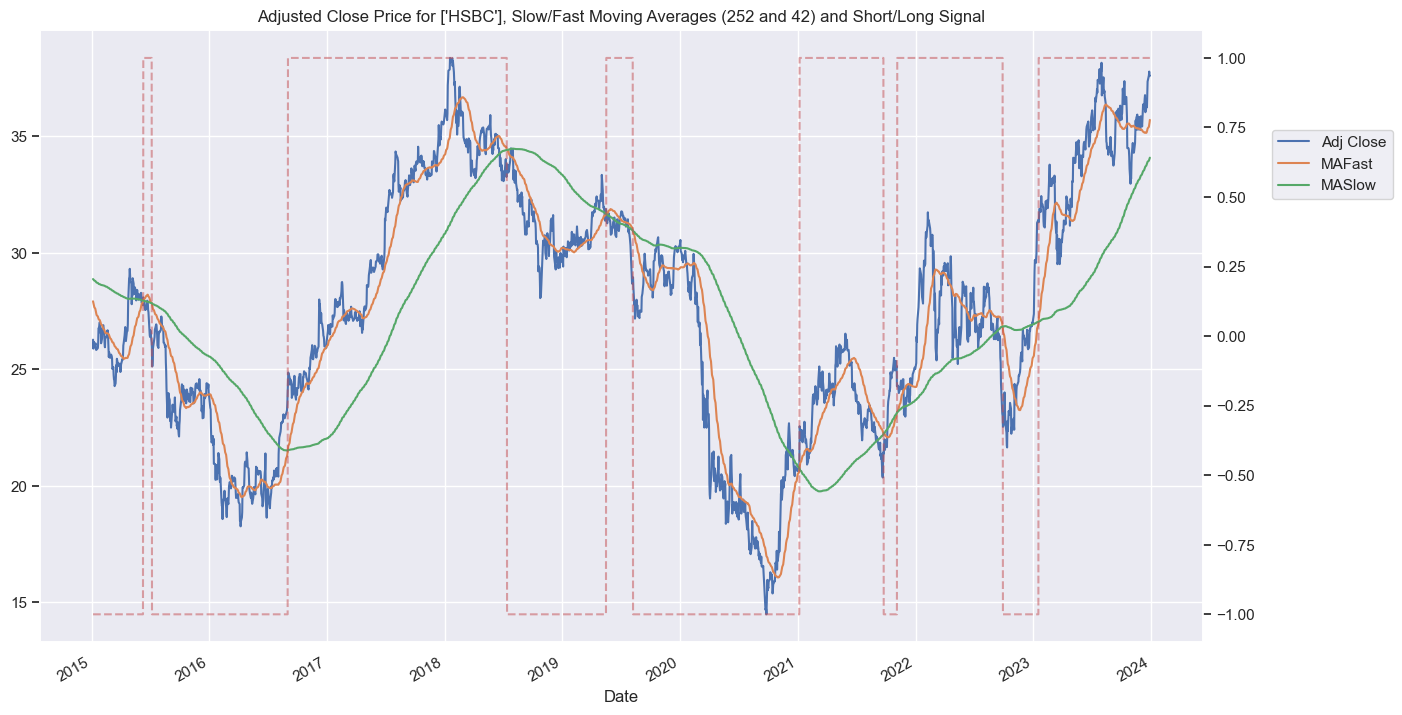

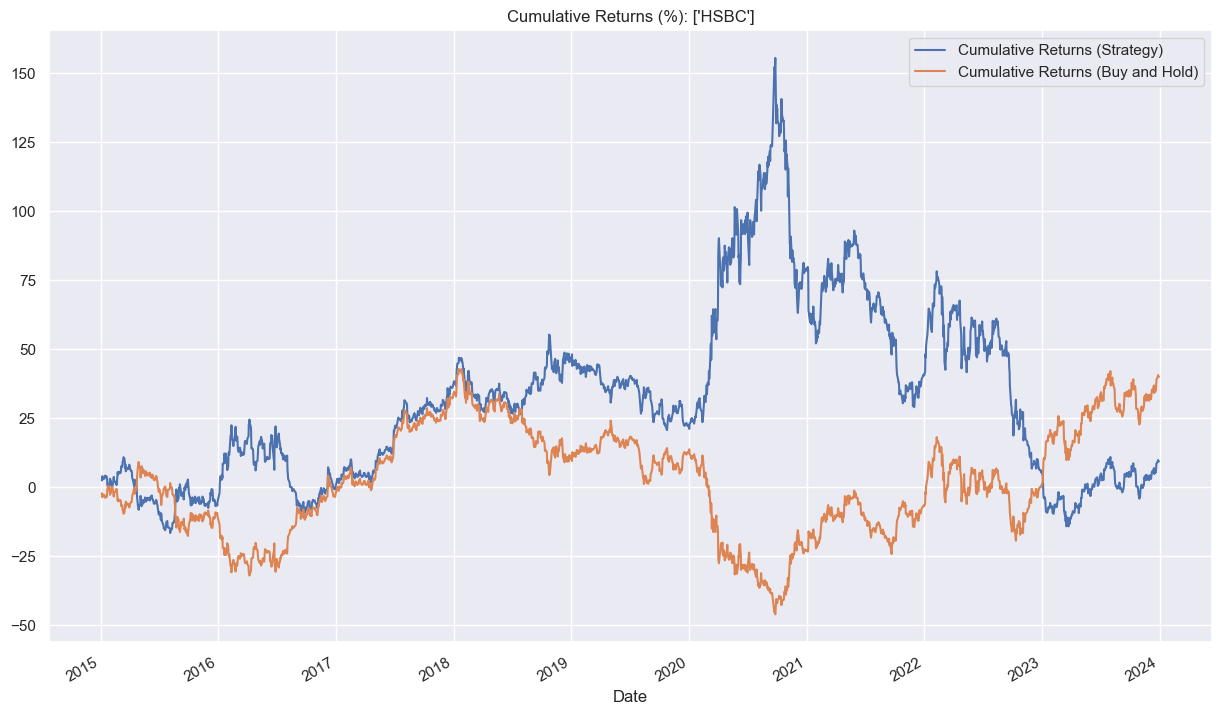



Total Returns: ['HSBC']
Market Total Return: 39.859%
Strategy Total Return: 9.218%


Annualized Volatility: ['HSBC']
Market Volatility: 0.25308%
Strategy Volatility: 0.25309%


In [223]:
stock =['HSBC']
start = pd.to_datetime('2014-01-01') 
end = pd.to_datetime('2024-01-01')
MAF = 42
MAS =252

MA_Strategy(stock,start,end,MAF,MAS)

We can make a shorter script that gives us only the total returns, for convenience

In [224]:
def MA_Strategy_Short(stock, start, end, MAF, MAS):
    try:
        data = yf.download(stock, start=start, end=end)
    except Exception as e:
        print(f"Failed to download data for {stock}: {e}")
        return
    
    if data.empty:
        print(f"No data found for {stock}")
        return

    # Calculate log returns
    data['Log Returns'] = np.log(data['Adj Close'] / data['Adj Close'].shift(1))
    data.dropna(inplace=True)

    # Calculate moving averages
    data['MASlow'] = data['Adj Close'].rolling(MAS).mean()
    data['MAFast'] = data['Adj Close'].rolling(MAF).mean()
    data.dropna(inplace=True)

    # Generate trading signals
    data['Signal'] = np.where(data['MAFast'] > data['MASlow'], 1, -1)
    data.dropna(inplace=True)

    # Calculate strategy log returns
    data['Strategy Log Returns'] = data['Log Returns'] * data['Signal'].shift(1)
    data.dropna(inplace=True)

    # Print performance metrics
    print('\n')
    print(f'Total Returns: {stock}')
    print(35 * '=')
    print(f'Market Total Return: {((np.exp(data[['Log Returns', 'Strategy Log Returns']].sum()) - 1) * 100).round(3).iloc[0]}%')
    print(f'Strategy Total Return: {((np.exp(data[['Log Returns', 'Strategy Log Returns']].sum()) - 1) * 100).round(3).iloc[1]}%')

In [225]:
stock = 'HSBC'  
start = pd.to_datetime('2014-01-01')
end = pd.to_datetime('2024-01-01')
MAF = 20
MAS = 180

MA_Strategy_Short(stock, start, end, MAF, MAS)

[*********************100%%**********************]  1 of 1 completed



Total Returns: HSBC
Market Total Return: 23.245%
Strategy Total Return: 90.736%


# ========================================================

Finally, we can try to optimize the strategy return by choosing different periods for the moving averages. We will consider a Fast MA interval of (10, 90) and a Slow MA interval of (100, 250). 

In [226]:
# Define the function to download and save data
def download_stock_data(stock, start, end):
    try:
        # Download the stock data
        data = yf.download(stock, start=start, end=end)
        if data.empty:
            print(f"No data found for {stock}")
            return
        # Save to CSV
        data.to_csv(f'{stock}.csv')
        print(f"Data for {stock} saved to {stock}.csv")
        # Load and display first few rows
        df = pd.read_csv(f'{stock}.csv')
        print(df.head(3))
    except Exception as e:
        print(f"Error: {e}")

# Example 
stock = 'HSBC' 
start = '2014-01-01'
end = '2024-01-01'

download_stock_data(stock, start, end)


[*********************100%%**********************]  1 of 1 completed

Data for HSBC saved to HSBC.csv
         Date       Open       High        Low      Close  Adj Close   Volume
0  2014-01-02  54.689999  54.750000  54.360001  54.570000  29.730536  1551300
1  2014-01-03  54.040001  54.419998  54.029999  54.090000  29.469027  1021100
2  2014-01-06  54.610001  54.810001  54.340000  54.360001  29.616133  1012200


In [227]:
sma1 = range(10, 90, 5)  
sma2 = range(100, 250, 10) 
stock = ['HSBC']
start = pd.to_datetime('2014-01-01') 
end = pd.to_datetime('2024-01-01')

show = pd.DataFrame()

for MAFast, MASlow in product(sma1, sma2): 
    # Load the data
    data = pd.read_csv('HSBC.csv')
    data.dropna(inplace=True)
    
    # Calculate log returns and moving averages
    data['Log Returns'] = np.log(data['Adj Close'] / data['Adj Close'].shift(1))
    data.dropna(inplace=True)
    data['MASlow'] = data['Adj Close'].rolling(MASlow).mean()
    data['MAFast'] = data['Adj Close'].rolling(MAFast).mean()
    data.dropna(inplace=True)
    data['Signal'] = np.where(data['MAFast'] > data['MASlow'], 1, -1)
    data['Strategy Log Returns'] = data['Log Returns'] * data['Signal'].shift(1)
    data.dropna(inplace=True)
    
    # Calculate returns
    ret = (np.exp(data[['Log Returns', 'Strategy Log Returns']].sum()) - 1) * 100
    
    # Create a DataFrame for the current parameters
    result = pd.DataFrame(
        {
            'MA Slow': [MASlow], 
            'MA Fast': [MAFast],
            'Market Return (%)': [ret['Log Returns'].round(3)],
            'Strategy Return (%)': [ret['Strategy Log Returns'].round(3)],
            'Difference in Returns (%)': [(ret['Strategy Log Returns'] - ret['Log Returns']).round(3)]
        }
    )
    
    # Append the results to the show DataFrame
    show = pd.concat([show, result], ignore_index=True)

print(show)


     MA Slow  MA Fast  Market Return (%)  Strategy Return (%)  \
0        100       10             27.544               87.202   
1        110       10             28.990              148.998   
2        120       10             31.004              145.297   
3        130       10             32.636              134.734   
4        140       10             27.495              138.667   
..       ...      ...                ...                  ...   
235      200       85             32.478               -5.487   
236      210       85             29.031               -8.931   
237      220       85             30.956              -31.284   
238      230       85             34.186              -30.586   
239      240       85             41.695                0.341   

     Difference in Returns (%)  
0                       59.658  
1                      120.008  
2                      114.293  
3                      102.099  
4                      111.171  
..                   

This gives us the following slow/fast moving average strategies, sorted in descending order from the one with the highest strategy return relative to the market return:

In [228]:
show.sort_values('Difference in Returns (%)', ascending= False).head(10)

,MA Slow,MA Fast,Market Return (%),Strategy Return (%),Difference in Returns (%)
92,120,40,31.004,351.276,320.271
106,110,45,28.990,322.603,293.613
78,130,35,32.636,286.130,253.494
91,110,40,28.990,270.350,241.360
93,130,40,32.636,266.458,233.823
61,110,30,28.990,262.481,233.491
62,120,30,31.004,261.557,230.552
79,140,35,27.495,249.687,222.192
33,130,20,32.636,253.045,220.409
77,120,35,31.004,251.191,220.187


[*********************100%%**********************]  1 of 1 completed


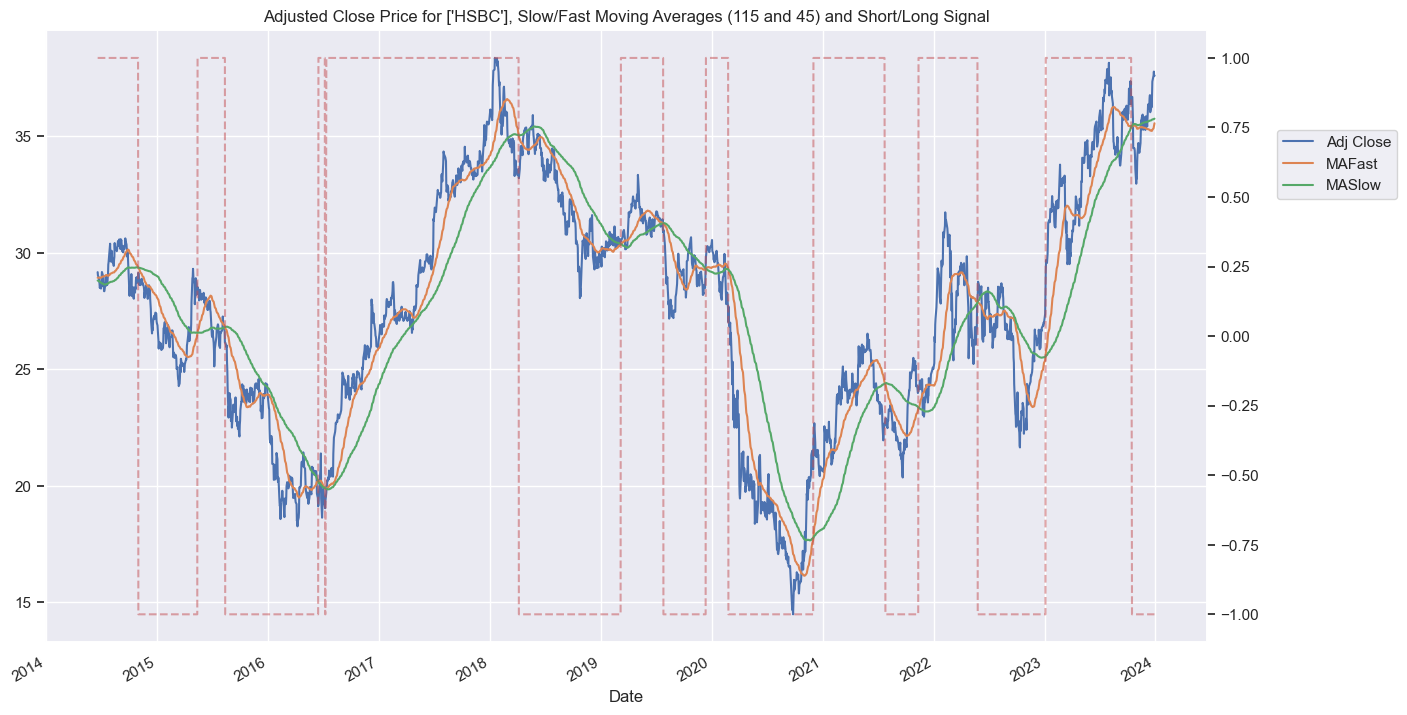

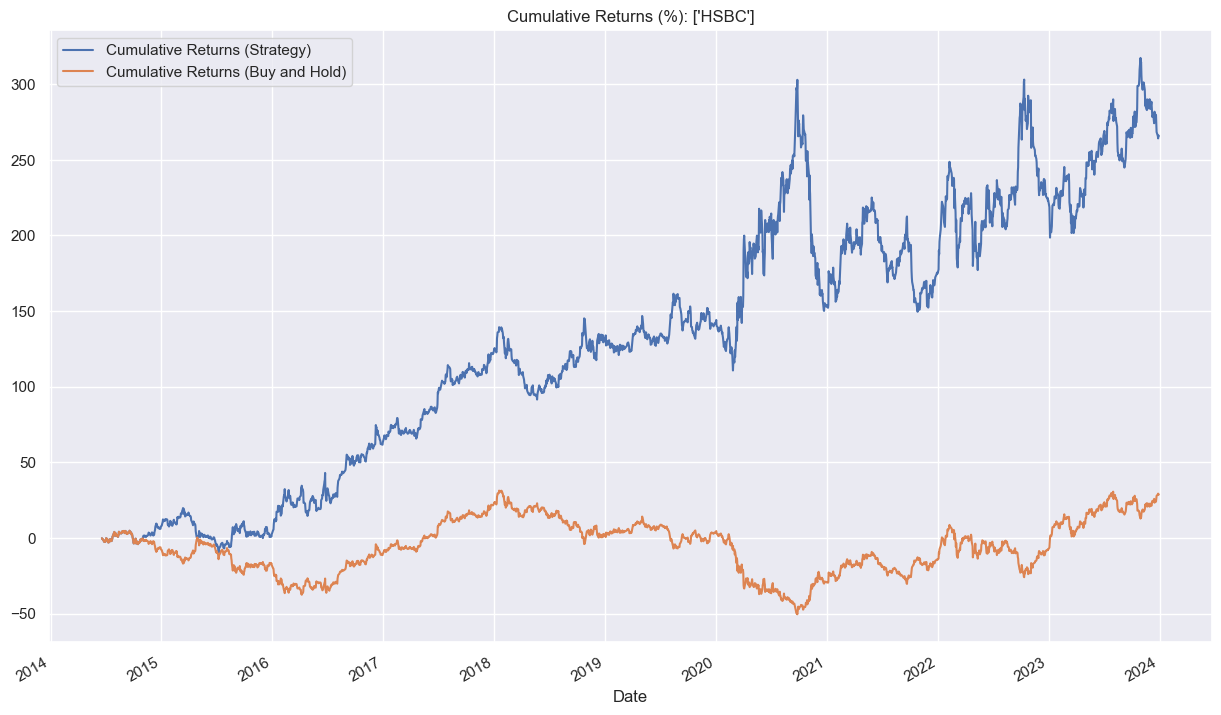



Total Returns: ['HSBC']
Market Total Return: 28.718%
Strategy Total Return: 265.837%


Annualized Volatility: ['HSBC']
Market Volatility: 0.2482%
Strategy Volatility: 0.24805%


In [229]:
stock =['HSBC']
start = pd.to_datetime('2014-01-01') 
end = pd.to_datetime('2024-01-01')
MAF =45
MAS =115

MA_Strategy(stock,start,end,MAF,MAS)